<a href="https://colab.research.google.com/github/vitoriaayres/vitoriaayres/blob/main/SOLAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math

Dados de Treinamento (Amostras): 1308
Dados de Teste (Amostras): 328

Iniciando o treinamento do modelo Random Forest...
Treinamento concluído.

--- Resultados da Avaliação ---
RMSE (Erro Quadrático Médio da Raiz): 845.18 kW
R² (Coeficiente de Determinação): 0.9887
------------------------------

Importância das Features (Fatores mais importantes para a previsão):
IRRADIACAO              0.992701
TEMPERATURA_MODULO      0.002284
TEMPERATURA_AMBIENTE    0.001412
DIA_DO_ANO              0.001224
HORA_COS                0.000846
HORA_SIN                0.000756
MINUTO_COS              0.000352
MINUTO_SIN              0.000326
MES                     0.000100
dtype: float64


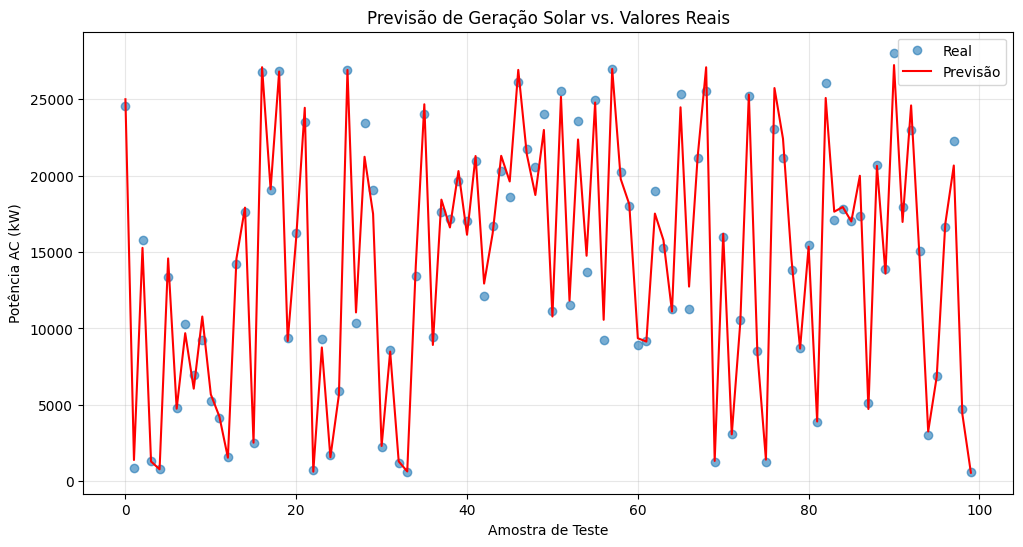


Estatísticas da Variável Alvo (POTENCIA_AC) para contexto:
count     1636.000000
mean     12933.990452
std       7893.957734
min          0.000000
25%       5707.931250
50%      13312.450000
75%      19113.776339
max      29150.212499
Name: POTENCIA_AC, dtype: float64


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math

try:
    df_gen = pd.read_csv('Plant_1_Generation_Data.csv')
    df_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
except FileNotFoundError:
    print("Erro: Verifique se os nomes dos arquivos estão corretos ou se o ambiente de execução tem acesso aos arquivos.")
    # Exit or handle the error appropriately if files are not found
    # For now, we'll assume the files are found after correcting the path

df_gen.rename(columns={
    'DATE_TIME': 'DATA_HORA',
    'PLANT_ID': 'ID_PLANTA',
    'SOURCE_KEY': 'CHAVE_FONTE',
    'DC_POWER': 'POTENCIA_DC',
    'AC_POWER': 'POTENCIA_AC',
    'DAILY_YIELD': 'PRODUCAO_DIARIA',
    'TOTAL_YIELD': 'PRODUCAO_TOTAL'
}, inplace=True)

df_weather.rename(columns={
    'DATE_TIME': 'DATA_HORA',
    'PLANT_ID': 'ID_PLANTA',
    'SOURCE_KEY': 'CHAVE_FONTE',
    'AMBIENT_TEMPERATURE': 'TEMPERATURA_AMBIENTE',
    'MODULE_TEMPERATURE': 'TEMPERATURA_MODULO',
    'IRRADIATION': 'IRRADIACAO'
}, inplace=True)


df_gen['DATA_HORA'] = pd.to_datetime(df_gen['DATA_HORA'], format='%d-%m-%Y %H:%M')
df_weather['DATA_HORA'] = pd.to_datetime(df_weather['DATA_HORA'])

df_gen_clean = df_gen.groupby('DATA_HORA')[['POTENCIA_AC', 'POTENCIA_DC', 'PRODUCAO_DIARIA']].sum().reset_index()


df_merged = pd.merge(df_gen_clean, df_weather, on='DATA_HORA', how='inner')


df_merged['HORA'] = df_merged['DATA_HORA'].dt.hour
df_merged['MINUTO'] = df_merged['DATA_HORA'].dt.minute # Adicionar minuto
df_merged['MES'] = df_merged['DATA_HORA'].dt.month
df_merged['DIA_DO_ANO'] = df_merged['DATA_HORA'].dt.dayofyear # Posição do sol no ano

df_merged['HORA_SIN'] = np.sin(2 * np.pi * df_merged['HORA'] / 24)
df_merged['HORA_COS'] = np.cos(2 * np.pi * df_merged['HORA'] / 24)
df_merged['MINUTO_SIN'] = np.sin(2 * np.pi * df_merged['MINUTO'] / 60)
df_merged['MINUTO_COS'] = np.cos(2 * np.pi * df_merged['MINUTO'] / 60)


features = [
    'IRRADIACAO',
    'TEMPERATURA_MODULO',
    'TEMPERATURA_AMBIENTE',
    'HORA_SIN', # Usar features cíclicas da hora
    'HORA_COS',
    'MINUTO_SIN', # Usar features cíclicas do minuto
    'MINUTO_COS',
    'MES',
    'DIA_DO_ANO'
]
target = 'POTENCIA_AC'

X = df_merged[features]
y = df_merged[target]


X_daytime = X[X['IRRADIACAO'] > 0.01]
y_daytime = y[X['IRRADIACAO'] > 0.01]


X_train, X_test, y_train, y_test = train_test_split(
    X_daytime, y_daytime, test_size=0.2, random_state=42
)

print(f"Dados de Treinamento (Amostras): {X_train.shape[0]}")
print(f"Dados de Teste (Amostras): {X_test.shape[0]}")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)


print("\nIniciando o treinamento do modelo Random Forest...")
rf_model.fit(X_train, y_train)
print("Treinamento concluído.")

y_pred = rf_model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))


r2 = r2_score(y_test, y_pred)

print("\n--- Resultados da Avaliação ---")
print(f"RMSE (Erro Quadrático Médio da Raiz): {rmse:.2f} kW")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")
print("------------------------------")


feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values(ascending=False)

print("\nImportância das Features (Fatores mais importantes para a previsão):")
print(feature_importances)


plt.figure(figsize=(12, 6))

plt.plot(y_test.values[:100], label='Real', marker='o', linestyle='None', alpha=0.6)
plt.plot(y_pred[:100], label='Previsão', linestyle='-', color='red')
plt.title('Previsão de Geração Solar vs. Valores Reais')
plt.xlabel('Amostra de Teste')
plt.ylabel('Potência AC (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nEstatísticas da Variável Alvo (POTENCIA_AC) para contexto:")
print(y_daytime.describe())

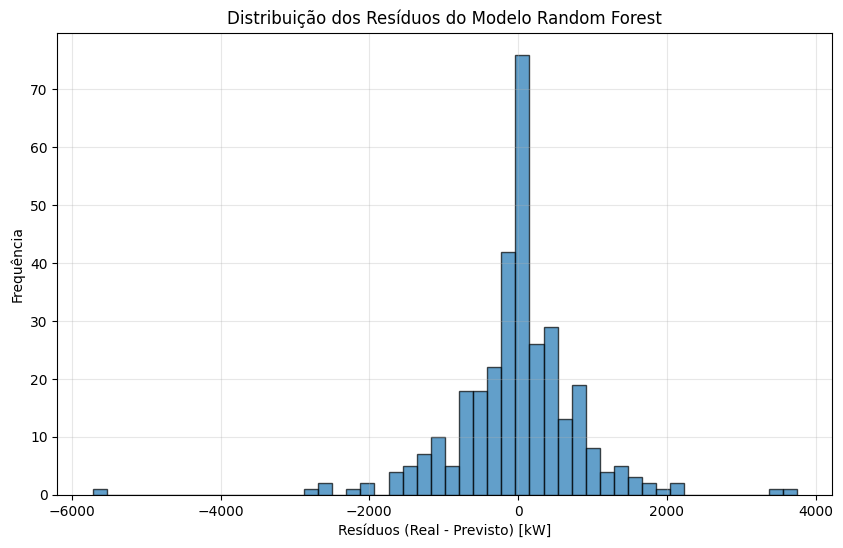


Estatísticas dos Resíduos:
count     328.000000
mean      -14.697677
std       846.347414
min     -5718.962323
25%      -359.355399
50%        15.243009
75%       363.467441
max      3751.968275
Name: POTENCIA_AC, dtype: float64


In [3]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribuição dos Resíduos do Modelo Random Forest')
plt.xlabel('Resíduos (Real - Previsto) [kW]')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)
plt.show()

print("\nEstatísticas dos Resíduos:")
print(pd.Series(residuals).describe())

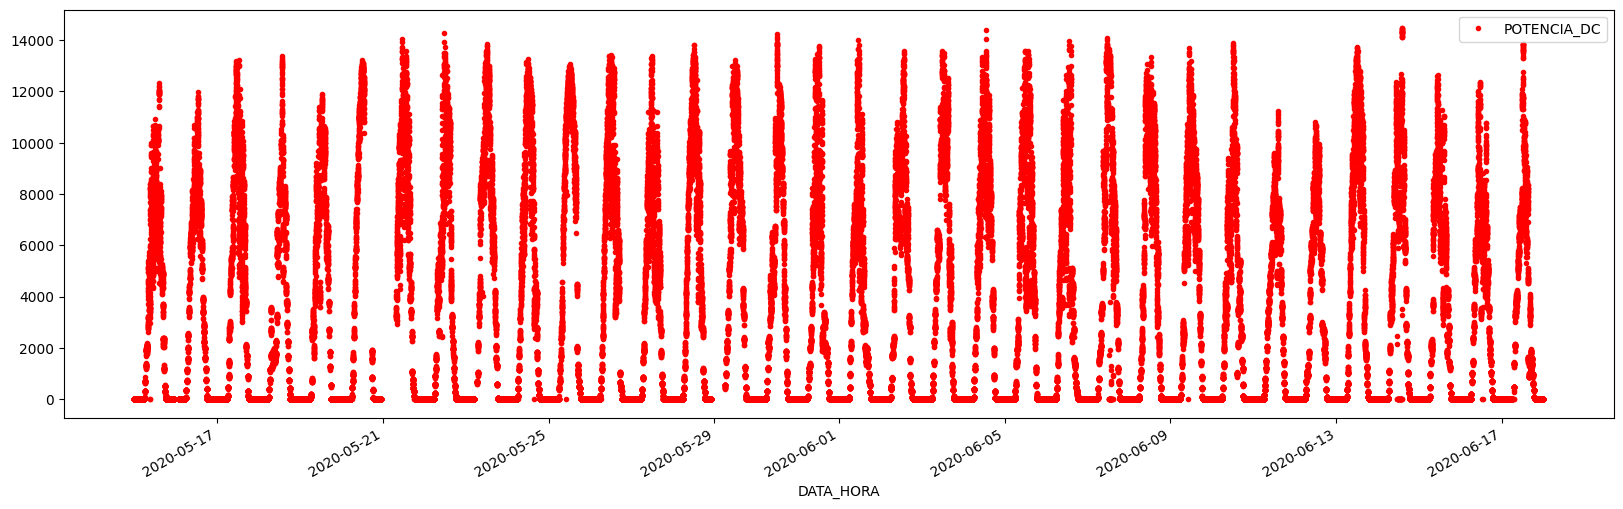

In [4]:
df_gen.plot(x= 'DATA_HORA', y='POTENCIA_DC', style='.', figsize = (20, 6),color= "red");

In [5]:
import plotly.express as px
fig = px.sunburst(df_merged, path=['MES', 'HORA', 'CHAVE_FONTE'], values='PRODUCAO_DIARIA')
fig.update_layout (height = 800 , width = 800)
fig.show()

In [6]:
df_merged['CHAVE_FONTE'].value_counts()

,count
CHAVE_FONTE,
HmiyD2TTLFNqkNe,3157


In [7]:
import plotly.express as px
import plotly.graph_objs as go

fig = px.scatter(df_merged, x = 'PRODUCAO_DIARIA', y = 'IRRADIACAO', log_x=True,
                 hover_name="CHAVE_FONTE", hover_data=["PRODUCAO_DIARIA", "IRRADIACAO"],
                color = 'PRODUCAO_DIARIA', color_continuous_scale= 'rainbow',
                title = 'Qualidade ou Quantidade, Essa é a Questão')
fig.show()